### Import packages for our notebook



In [ ]:
# Import Python packages
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import os
import plotly.express as px
import json
import sys

# Import Snowflake modules
from snowflake.snowpark import Session 
import snowflake.snowpark.functions as F 
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col


# Pandas Tools
from snowflake.connector.pandas_tools import write_pandas

# create_temp_table warning suppresion
import warnings; warnings.simplefilter('ignore')

from snowflake.snowpark.context import get_active_session
session = get_active_session()


### Connect to Snowflake



In [ ]:
hex_snowflake_conn = hextoolkit.get_data_connection('demo309')
session = hex_snowflake_conn.get_snowpark_session()
session.use_role('datasci')
session.use_warehouse('datasci_wh')
session.use_database('analytics')
session.use_schema('readmit')
print(session.sql("select current_role(), current_warehouse(), current_database(), current_schema(), current_region(), current_client()").collect())

[Row(CURRENT_ROLE()='DATASCI', CURRENT_WAREHOUSE()='DATASCI_WH', CURRENT_DATABASE()='ANALYTICS', CURRENT_SCHEMA()='READMIT', CURRENT_REGION()='PUBLIC.AWS_US_WEST_2', CURRENT_CLIENT()='PythonSnowpark 1.11.1')]


### Inspect the data in a Snowpark dataframe



In [ ]:
readmissions_df=session.table('readmissions_enriched')
readmissions_df.sample(n=10).show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CITY_LAT"  |"CITY_LONG"  |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"HOSPITAL_NAME"                                    |"HOSPITAL_STATE"  |"DIAGNOSIS"  |"PATIENT_NUMBER"  |"DV_READMIT_FLAG" 

### How large is the Snowpark dataframe in the Python runtime?



In [ ]:
import sys
snowpark_size = sys.getsizeof(readmissions_df) / (1024*1024)
print(f"Snowpark DataFrame Size (snowpark_df): {snowpark_size:.2f} MB")

Snowpark DataFrame Size (snowpark_df): 0.00 MB


### Explore Snowpark Dataframe API



In [ ]:
co_df = readmissions_df.filter(F.col("HOSPITAL_STATE") == 'CO').order_by(["DV_READMIT_FLAG", "DIAGNOSIS"], ascending=[0, 0])
co_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT  *  FROM readmissions_enriched WHERE ("HOSPITAL_STATE" = 'NJ') ORDER BY "DV_READMIT_FLAG" DESC NULLS LAST, "DIAGNOSIS" DESC NULLS LAST
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=5365760
Operations:
1:0     ->Result  READMISSIONS_ENRICHED.CITY_LAT, READMISSIONS_ENRICHED.CITY_LONG, READMISSIONS_ENRICHED.HOSPITAL_LAT, READMISSIONS_ENRICHED.HOSPITAL_LONG, READMISSIONS_ENRICHED.HOSPITAL_NAME, READMISSIONS_ENRICHED.HOSPITAL_STATE, READMISSIONS_ENRICHED.DIAGNOSIS, READMISSIONS_ENRICHED.PATIENT_NUMBER, READMISSIONS_ENRICHED.DV_READMIT_FLAG, READMISSIONS_ENRICHED.ADMIT_DATE, READMISSIONS_ENRICHED.LENGTH_OF_STAY, READMISSIONS_ENRICHED.PRIOR_IP_ADMITS, READMISSIONS_ENRICHED.CHRONIC_CONDITIONS_NUMBER, READMISSIONS_ENRICHED.PATIENT_AGE, READMISSIONS_ENRICHED.ORDER_SET_USED, READMISSIONS_ENRICHED.HOSPITAL_ID, READMISSIONS_ENRICHED.HOSPITAL_ADDRESS, READMISSIONS_ENRICHED.HOSPIT

### Select columns for modeling



In [ ]:
readmissions_df_features = readmissions_df.select("PATIENT_AGE", "BMI", "LENGTH_OF_STAY", "ORDER_SET_USED", "CHRONIC_CONDITIONS_NUMBER",  "SBUX_COUNT", "DV_READMIT_FLAG", "HOSPITAL_NAME", "HOSPITAL_LAT", "HOSPITAL_LONG" )

#Inspect columns for missing values and replace null values with 0
column_names=readmissions_df_features.columns
readmissions_df_features = readmissions_df_features.fillna(0, subset="SBUX_COUNT")
for i in column_names:
    print('Column',i,'has',readmissions_df_features.filter(col(i).isNull()).count(),'missing values!')

Column PATIENT_AGE has 0 missing values!
Column BMI has 0 missing values!
Column LENGTH_OF_STAY has 0 missing values!
Column ORDER_SET_USED has 0 missing values!
Column CHRONIC_CONDITIONS_NUMBER has 0 missing values!
Column SBUX_COUNT has 0 missing values!
Column DV_READMIT_FLAG has 0 missing values!
Column HOSPITAL_NAME has 0 missing values!
Column HOSPITAL_LAT has 949 missing values!
Column HOSPITAL_LONG has 949 missing values!


### Save modeling dataframe as a table in Snowflake



In [ ]:
readmissions_df_features.write.mode("overwrite").save_as_table("analytics.readmit.readmissions_imp")

### Define and train XG Boost Classifier using SciKitLearn syntax that is 100% pushed down to Snowflake



In [ ]:
from snowflake.ml.modeling.xgboost import XGBClassifier

#Train/test split
readmits_train_df, readmits_test_df = session.table("readmissions_imp").drop('ROW').random_split(weights=[0.8, 0.2], seed=0)

#Specify columns for modeling
feature_cols = ["PATIENT_AGE",'BMI','LENGTH_OF_STAY','ORDER_SET_USED','CHRONIC_CONDITIONS_NUMBER', 'SBUX_COUNT'] 
target_col = "DV_READMIT_FLAG"
output_col = "PREDICTED_READMIT_FLAG"

#Create our classifier
classifier = XGBClassifier(
    input_cols=feature_cols,
    label_cols=target_col,
    output_cols=output_col
)

# Train
classifier.fit(readmits_train_df)

# Eval
result = classifier.predict(readmits_test_df)


# Analyze results
df = result["DV_READMIT_FLAG", "PREDICTED_READMIT_FLAG"].to_pandas()
df.head()

,DV_READMIT_FLAG,PREDICTED_READMIT_FLAG
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1


### Inspect our results with a confusion matrix



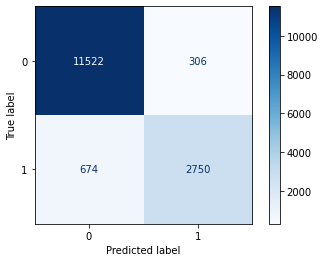

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
actuals=df["DV_READMIT_FLAG"].astype(str)
predicts=df["PREDICTED_READMIT_FLAG"].astype(str)
cm = confusion_matrix(actuals, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


### Hyperparameter optimization with SciKitLearn GridSearch



In [ ]:
from snowflake.ml.modeling.model_selection import GridSearchCV

#Specify grid search area
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.01, 0.05, 0.1, 0.25, 0.5],
    },
    n_jobs = -1,
    scoring="roc_auc",
    input_cols=feature_cols,
    label_cols=target_col,
    output_cols=output_col
)

# Train
grid_search.fit(readmits_train_df)

### Analyze grid search results



In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display


gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
ROC_val = gs_results["mean_test_score"]

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "ROC":ROC_val})

display(gs_results_df.sort_values('ROC', ascending=False).head(10))

,n_estimators,learning_rate,ROC
4,500,0.01,0.965102
5,100,0.05,0.965085
6,200,0.05,0.964953
10,100,0.10,0.964938
3,400,0.01,0.964923
2,300,0.01,0.964592
7,300,0.05,0.964486
8,400,0.05,0.964100
11,200,0.10,0.964033
9,500,0.05,0.963714


### Analyze the parameters of the best estimator found through the grid search 



In [ ]:
grid_search.to_sklearn().best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bynode=None,
 colsample_bytree=None, early_stopping_rounds=None,
 enable_categorical=False, eval_metric=None, feature_types=None,
 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
 interaction_constraints=None, learning_rate=0.01, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=None, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=None, ...) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. XGBClassifier XGBClassifier(base_score=None, booster=None, callbacks=None,
 colsample_bylevel=None, colsample_bynode=None,
 colsample_bytree=None, early_stopping_rounds=None,
 enable_categorical=False, eval_metric=None, feature_types=None,
 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
 interaction_constraints=None, learning_rate=0.01, max_bin=None,
 max_cat_threshold=None, max_cat_to_onehot=None,
 max_delta_step=None, max_depth=None, max_leaves=None,
 min_child_weight=None, missing=nan, monotone_constraints=None,
 n_estimators=500, n_jobs=None, num_parallel_tree=None,
 predictor=None, random_state=None, ...)

### Create the registry where our model will reside in deployment



In [ ]:
import importlib
from snowflake.ml.registry import model_registry

def delete_registry(session):
    session.sql("DROP SCHEMA IF EXISTS ANALYTICS._SYSTEM_MODEL_REGISTRY_SCHEMA").collect()

def create_registry(session):
    from snowflake.ml.registry import model_registry
    create = model_registry.create_model_registry(session=session, database_name="ANALYTICS")
    registry = model_registry.ModelRegistry(session=session, database_name="ANALYTICS")
    return registry

delete_registry(session)
registry = create_registry(session)

### Log the best model from grid search



In [ ]:
X = readmits_train_df.select(feature_cols).limit(100)
model_version = 'v1'
model_id = registry.log_model(model=grid_search, model_name="readmissions_XGBClassifier", model_version=model_version, sample_input_data=X, options={"embed_local_ml_library": True})

### Create the assessment metric to use for performance tracking in deployment



In [ ]:
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate

optimal_roc = gs_results_df.loc[(gs_results_df['n_estimators']==optimal_n_estimators) &
                                 (gs_results_df['learning_rate']==optimal_learning_rate), 'ROC'].values[0]

### Create model reference and add metrics to the model we just logged



In [ ]:
registry_model = model_registry.ModelReference(registry=registry, model_name="readmissions_XGBClassifier", model_version=model_version)
registry_model.set_metric(metric_name='ROC', metric_value=optimal_roc)
registry_model.set_model_description(description="This is a demo XG Boost Clasifier trained using Snowpark ML to predict patient readmissions.")

### Inspect our model in the registry



In [ ]:
registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TRAINING_DATASET_ID,TYPE,URI,VERSION,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.8.13""\n}","""DATASCI""",2024-01-22 11:43:18.688000-08:00,7b86742cb95e11ee8e0e02a4eae1cefc,None,readmissions_XGBClassifier,None,None,None,snowml,sfc://ANALYTICS._SYSTEM_MODEL_REGISTRY_SCHEMA....,v1,"""This is a demo XG Boost Clasifier trained usi...","{\n ""ROC"": 0.9651022795308645\n}",None,2024-01-22 11:43:19.608000-08:00


### Get best fitting model by querying registry



In [ ]:
# If you have more models logged, it will select among them. For now, we've already used grid search to just log the best model
from snowflake.ml.registry import model_registry
best_model_version = registry.list_models().filter(F.col("NAME") == "readmissions_XGBClassifier").sort(F.parse_json("METRICS")['ROC'], ascending=False).collect()[0]['VERSION']
best_model = model_registry.ModelReference(registry=registry, model_name="readmissions_XGBClassifier", model_version=best_model_version)
print("Best model version based on ROC: {}".format(best_model_version))

Best model version based on ROC: v1


### Create a stage to save our deployed model code (the underlying UDF file)



In [ ]:
session.sql('CREATE OR REPLACE STAGE modeling_assets;').collect()

[Row(status='Stage area MODELING_ASSETS successfully created.')]

### Deploy the model



In [ ]:
best_model.deploy(deployment_name="readmissions_XGBClassifier_UDF", target_method="predict", permanent=True, options={"relax_version": True, "replace_udf": True})b

Generated UDF file is persisted at: /tmp/tmpv0qyn4ar.py
ANALYTICS._SYSTEM_MODEL_REGISTRY_SCHEMA.readmissions_XGBClassifier_UDF is deployed to warehouse.


### Predict on test data



In [ ]:
result_sdf = best_model.predict("readmissions_XGBClassifier_UDF", readmits_test_df)
result_sdf.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"DV_READMIT_FLAG"  |"HOSPITAL_NAME"       |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"PATIENT_AGE"  |"BMI"  |"LENGTH_OF_STAY"  |"ORDER_SET_USED"  |"CHRONIC_CONDITIONS_NUMBER"  |"SBUX_COUNT"  |"PREDICTED_READMIT_FLAG"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0                  |OCEAN MEDICAL CENTER  |NULL            |NULL             |52             |28.4   |3                 |0                 |2                            |0             |0                         |
|0                  |OCEAN MEDICAL CENTER  |NULL            |NULL             |56             |23.2   |3                 |1                 |2  

### Inspect the results of our test scoring with our deployed model



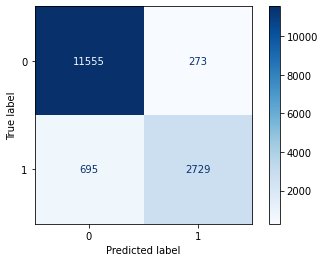

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
df = result_sdf["DV_READMIT_FLAG", "PREDICTED_READMIT_FLAG"].to_pandas()
actuals=df["DV_READMIT_FLAG"].astype(str)
predicts=df["PREDICTED_READMIT_FLAG"].astype(str)
cm = confusion_matrix(actuals, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


### Visualize on a map



In [ ]:
# Pull predictions aggregated by provider into a pandas dataframe
pred_map_df = result_sdf.groupBy("HOSPITAL_NAME", "HOSPITAL_LAT", "HOSPITAL_LONG").agg(F.sum("PREDICTED_READMIT_FLAG").alias("TOTAL_PRED_READMITS")).to_pandas()

# This is a prototype of what we'll eventually make in Tableau
# Where are our providers with the most predicted readmissions?
fig = px.scatter_mapbox(
    pred_map_df, 
    lat="HOSPITAL_LAT", 
    lon="HOSPITAL_LONG", 
    hover_name="HOSPITAL_NAME", 
    size="TOTAL_PRED_READMITS",
    color="TOTAL_PRED_READMITS",
    zoom=8, 
    height=800,
    width=1000
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [ ]:
session.close()

In [ ]:
hex_snowflake_conn = hextoolkit.get_data_connection('demo309')
session = hex_snowflake_conn.get_snowpark_session()
session.use_role('accountadmin')
session.use_warehouse('demo_wh')
session.use_database('demo')
session.use_schema('test')
print(session.sql("select current_role(), current_warehouse(), current_database(), current_schema(), current_region(), current_client()").collect())

[Row(CURRENT_ROLE()='ACCOUNTADMIN', CURRENT_WAREHOUSE()='DEMO_WH', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='TEST', CURRENT_REGION()='PUBLIC.AWS_US_WEST_2', CURRENT_CLIENT()='PythonSnowpark 1.19.0')]


In [ ]:
snowpark_df = session.table("STUDENTOUTCOMES")
snowpark_df.show(n=2)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"STUDENT_ID"  |"AGE"  |"GENDER"  |"HIGH_SCHOOL_GPA"  |"SAT_SCORE"  |"COLLEGE_MAJOR"  |"STUDY_HRS_PER_WK"  |"EXTRACURRICULAR_ACTIVITIES"  |"FAMILY_INCOME"  |"PARENT_EDUCATION_LEVEL"  |"ATTENDANCE_RATE"  |"CURRENT_GPA"  |"ZIP_CODE"  |"GRADUATION_STATUS"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1             |21     |Other     |2.33               |1142         |Arts             |17                  |4                             |69263            |Master Degree             |0.9                |3.82           |20092       

In [ ]:
#one hot encoding of College Major and Gender
import snowflake.ml.modeling.preprocessing as snowml

snowml_ohe = snowml.OneHotEncoder(input_cols=["GENDER", "COLLEGE_MAJOR"], 
                                output_cols=["GENDER_OHE", "COLLEGE_MAJOR_OHE"])
transformed_df = snowml_ohe.fit(snowpark_df).transform(snowpark_df)

np.array(transformed_df.columns)

array(['"GENDER_OHE_Female"', '"GENDER_OHE_Male"', '"GENDER_OHE_Other"',
       '"COLLEGE_MAJOR_OHE_Arts"', '"COLLEGE_MAJOR_OHE_Business"',
       '"COLLEGE_MAJOR_OHE_Education"', '"COLLEGE_MAJOR_OHE_Engineering"',
       '"COLLEGE_MAJOR_OHE_Law"', '"COLLEGE_MAJOR_OHE_Medicine"',
       '"COLLEGE_MAJOR_OHE_Science"', 'STUDENT_ID', 'AGE', 'GENDER',
       'HIGH_SCHOOL_GPA', 'SAT_SCORE', 'COLLEGE_MAJOR',
       'STUDY_HRS_PER_WK', 'EXTRACURRICULAR_ACTIVITIES', 'FAMILY_INCOME',
       'PARENT_EDUCATION_LEVEL', 'ATTENDANCE_RATE', 'CURRENT_GPA',
       'ZIP_CODE', 'GRADUATION_STATUS'], dtype='<U31')

In [ ]:
input_col = ["PARENT_EDUCATION_LEVEL"]
output_col = "PARENT_EDUCATION_LEVEL_OE"

# my_oe_encoder = snowml.OrdinalEncoder(input_cols=oe_cols, categories=[['High School', 'Associate Degree', 'Bachelor Degree', 'Master Degree', 'PhD']])


# my_oe_encoder = snowml.OrdinalEncoder(categories:['High School','Associate Degree','Bachelor Degree','Master Degree', 'PhD'],
#                                       input_cols=oe_cols,
#                                       output_cols='PARENT_EDUCATION_LEVEL_OE',
#                                       )
# transformed_df[oe_cols] = my_oe_encoder.fit(transformed_df[oe_cols])
# my_oe_encoder.fit(transformed_df)
# encoded_df = my_oe_encoder.transform(transformed_df)

categories = {
    "PARENT_EDUCATION_LEVEL": [
        "High School",
        "Associate Degree",
        "Bachelor Degree",
        "Master Degree",
        "PhD",
    ]
}
# Given list of categories
# categories = [['High School', 'Associate Degree', 'Bachelor Degree', 'Master Degree', 'PhD']]
# categories_array = np.array(categories)
# data_dict = {'education_levels': categories_array}
my_oe_encoder = snowml.OrdinalEncoder(
    input_cols=input_col, output_cols=[output_col], categories=categories
)
my_oe_encoder.fit(transformed_df)
encoded_df = my_oe_encoder.transform(transformed_df)

# encoded_df.show(5)

# my_oe_encoder = OrdinalEncoder(input_cols=oe_cols, output_cols=oe_cols)
# my_oe_encoder.fit(application_record_sdf)
# application_record_sdf = my_oe_encoder.transform(application_record_sdf)